In [1]:
import os
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

## File compression

### Compare png compression level 9 and WebP format as alternatives to native png

In [36]:
# --- Configuration ---
# *** Point this to your actual data directory ***
# You might need to import it from your shared config if the notebook can see it,
# otherwise, define it manually here for the test.
# Option 1: Import (if notebook environment allows)
try:
    from phorest_pipeline.shared.config import DATA_DIR

    print(f'Using DATA_DIR from config: {DATA_DIR}')
except ImportError:
    print('Could not import DATA_DIR from config, defining manually.')
    DATA_DIR = Path('./data')  # Assumes 'data' is in the same dir as the notebook

output_dir_name = 'compression_test'
num_timing_runs = 5  # Number of times to repeat timing for averaging

# --- Validate Data Directory ---
if not DATA_DIR.is_dir():
    print(f'[ERROR] Data directory not found: {DATA_DIR.resolve()}')
    raise FileNotFoundError(f'Data directory not found: {DATA_DIR.resolve()}')

# --- Find Existing PNG Images ---
print(f'\nLooking for existing PNG images in: {DATA_DIR.resolve()}')
existing_pngs = list(DATA_DIR.glob('*.png'))

if not existing_pngs:
    print(f"[ERROR] No 'image_*.png' files found in {DATA_DIR}. Cannot proceed.")
    raise FileNotFoundError(f'No PNG images found in {DATA_DIR}')
else:
    print(f'Found {len(existing_pngs)} PNG images.')
    test_image_path = existing_pngs[0]
    print(f'Using image for testing: {test_image_path.name}')

    # --- Create Output Directory ---
    output_dir = Path(output_dir_name)
    output_dir.mkdir(exist_ok=True)
    print(f'Output files will be saved in: {output_dir.resolve()}')

    # --- Load the Sample Frame ---
    print('\nLoading the sample frame...')
    # Load in color (usually preferred for saving, even if analysis was grayscale)
    sample_frame = cv2.imread(str(test_image_path), cv2.IMREAD_GRAYSCALE)

    if sample_frame is None:
        print(f'[ERROR] Failed to load image file: {test_image_path}. Cannot proceed.')
    else:
        print(f'Sample frame loaded successfully. Shape: {sample_frame.shape}')

        # --- Test Baseline PNG (Re-saving the loaded PNG) ---
        print('\n--- Testing Baseline PNG (Default Compression) ---')
        baseline_filepath = output_dir / f'resave_{test_image_path.stem}_baseline.png'
        start_time = time.perf_counter()
        saved_baseline = cv2.imwrite(str(baseline_filepath), sample_frame)
        end_time = time.perf_counter()

        if saved_baseline:
            baseline_size = baseline_filepath.stat().st_size
            baseline_time = end_time - start_time
            print(f'Saved: {baseline_filepath.name}')
            print(f'  Size: {baseline_size / 1024:.2f} KB')
            print(f'  Time: {baseline_time:.4f} seconds')
            # Compare to the *original* file size
            original_size = test_image_path.stat().st_size
            print(
                f'  vs Original Size ({original_size / 1024:.2f} KB): {(baseline_size / original_size * 100):.2f}%'
            )
        else:
            print('[ERROR] Failed to save baseline PNG.')
            baseline_size = -1
            baseline_time = -1

        # --- Test PNG Level 9 Compression ---
        print('\n--- Testing PNG Level 9 Compression ---')
        png9_filepath = output_dir / f'resave_{test_image_path.stem}_png9.png'
        png9_params = [cv2.IMWRITE_PNG_COMPRESSION, 9]
        start_time = time.perf_counter()
        saved_png9 = cv2.imwrite(str(png9_filepath), sample_frame, png9_params)
        end_time = time.perf_counter()

        if saved_png9:
            png9_size = png9_filepath.stat().st_size
            png9_time = end_time - start_time
            print(f'Saved: {png9_filepath.name}')
            print(f'  Size: {png9_size / 1024:.2f} KB')
            print(f'  Time: {png9_time:.4f} seconds')
            if baseline_size > 0:
                print(f'  Saving vs Baseline Resave: {(png9_size / baseline_size * 100):.2f}%')
            print(f'  Saving vs Original: {(png9_size / original_size * 100):.2f}%')
        else:
            print('[ERROR] Failed to save PNG Level 9.')
            png9_size = -1
            png9_time = -1

        # --- Test Lossless WebP Compression ---
        print('\n--- Testing Lossless WebP Compression ---')
        webp_filepath = output_dir / f'resave_{test_image_path.stem}_lossless.webp'
        webp_params = [cv2.IMWRITE_WEBP_QUALITY, 100]  # Quality 100 = lossless
        start_time = time.perf_counter()
        saved_webp = cv2.imwrite(str(webp_filepath), sample_frame, webp_params)
        end_time = time.perf_counter()

        if saved_webp:
            webp_size = webp_filepath.stat().st_size
            webp_time = end_time - start_time
            print(f'Saved: {webp_filepath.name}')
            print(f'  Size: {webp_size / 1024:.2f} KB')
            print(f'  Time: {webp_time:.4f} seconds')
            if baseline_size > 0:
                print(f'  Saving vs Baseline Resave: {(webp_size / baseline_size * 100):.2f}%')
            print(f'  Saving vs Original: {(webp_size / original_size * 100):.2f}%')
        else:
            print('[ERROR] Failed to save Lossless WebP.')
            webp_size = -1
            webp_time = -1

        # --- Optional: Average Timings ---
        print(f'\n--- Averaging Timings over {num_timing_runs} runs ---')
        # Use the already loaded sample_frame for timing consistency
        times = {'baseline': [], 'png9': [], 'webp': []}

        for i in range(num_timing_runs):
            print(f'Timing run {i + 1}/{num_timing_runs}...')
            # Time baseline PNG
            t_start = time.perf_counter()
            cv2.imwrite(str(output_dir / f'timing_baseline_{i}.png'), sample_frame)
            times['baseline'].append(time.perf_counter() - t_start)
            try:
                os.remove(output_dir / f'timing_baseline_{i}.png')  # Clean up
            except OSError:
                pass

            # Time PNG Level 9
            t_start = time.perf_counter()
            cv2.imwrite(str(output_dir / f'timing_png9_{i}.png'), sample_frame, png9_params)
            times['png9'].append(time.perf_counter() - t_start)
            try:
                os.remove(output_dir / f'timing_png9_{i}.png')  # Clean up
            except OSError:
                pass

            # Time Lossless WebP
            t_start = time.perf_counter()
            cv2.imwrite(str(output_dir / f'timing_webp_{i}.webp'), sample_frame, webp_params)
            times['webp'].append(time.perf_counter() - t_start)
            try:
                os.remove(output_dir / f'timing_webp_{i}.webp')  # Clean up
            except OSError:
                pass

        print('\n--- Average Save Times ---')
        for method, timing_list in times.items():
            if timing_list:
                avg_time = sum(timing_list) / len(timing_list)
                print(f'{method}: {avg_time:.4f} seconds')
            else:
                print(f'{method}: No successful timings recorded.')
        print('------------------------')

# --- End of script ---


Using DATA_DIR from config: data

Looking for existing PNG images in: /Users/chris/Documents/Documents/SoftwareDev/Python/Phorest/Phorest_pipeline/data
Found 10 PNG images.
Using image for testing: image_20250403_133402_863762_cam1.png
Output files will be saved in: /Users/chris/Documents/Documents/SoftwareDev/Python/Phorest/Phorest_pipeline/compression_test

Loading the sample frame...
Sample frame loaded successfully. Shape: (960, 1280)

--- Testing Baseline PNG (Default Compression) ---
Saved: resave_image_20250403_133402_863762_cam1_baseline.png
  Size: 349.86 KB
  Time: 0.0136 seconds
  vs Original Size (349.86 KB): 100.00%

--- Testing PNG Level 9 Compression ---
Saved: resave_image_20250403_133402_863762_cam1_png9.png
  Size: 296.49 KB
  Time: 0.9119 seconds
  Saving vs Baseline Resave: 84.75%
  Saving vs Original: 84.75%

--- Testing Lossless WebP Compression ---
Saved: resave_image_20250403_133402_863762_cam1_lossless.webp
  Size: 115.05 KB
  Time: 0.1070 seconds
  Saving vs B

### Calculate difference between original png and compressed versions

In [37]:
# Optional: For SSIM comparison (requires scikit-image: uv pip install scikit-image)
# from skimage.metrics import structural_similarity as ssim

# --- Configuration ---
# *** Use the SAME paths and logic as the previous script to find the files ***

# Import DATA_DIR
try:
    from phorest_pipeline.shared.config import DATA_DIR

    print(f'Using DATA_DIR from config: {DATA_DIR}')
except ImportError:
    print('Could not import DATA_DIR from config, defining manually.')
    DATA_DIR = Path('./data')

output_dir_name = 'compression_test'  # Directory where test files were saved
output_dir = Path(output_dir_name)

# --- Find the Original Test Image ---
if not DATA_DIR.is_dir():
    print(f'[ERROR] Data directory not found: {DATA_DIR.resolve()}')
    raise FileNotFoundError(f'Data directory not found: {DATA_DIR.resolve()}')

existing_pngs = list(DATA_DIR.glob('*.png'))
if not existing_pngs:
    print(f"[ERROR] No '*.png' files found in {DATA_DIR}. Cannot proceed.")
    raise FileNotFoundError(f'No PNG images found in {DATA_DIR}')

original_image_path = existing_pngs[0]  # Use the same image as tested before
print(f'Using original image for comparison: {original_image_path.name}')

# --- Define Paths to Compressed Files (Based on previous script's naming) ---
png9_filename = f'resave_{original_image_path.stem}_png9.png'
webp_filename = f'resave_{original_image_path.stem}_lossless.webp'

png9_filepath = Path(output_dir, png9_filename)
webp_filepath = Path(output_dir, webp_filename)

# --- Check if Test Output Files Exist ---
files_ok = True
if not output_dir.is_dir():
    print(f'[ERROR] Test output directory not found: {output_dir.resolve()}')
    files_ok = False
if not original_image_path.exists():
    print(f'[ERROR] Original image file not found: {original_image_path}')
    files_ok = False
if not png9_filepath.exists():
    print(f'[ERROR] PNG Level 9 test file not found: {png9_filepath}')
    files_ok = False
if not webp_filepath.exists():
    print(f'[ERROR] Lossless WebP test file not found: {webp_filepath}')
    files_ok = False

if not files_ok:
    print(
        '\nOne or more required image files are missing. Please run the compression test script first.'
    )
else:
    print('\nAll required image files found. Proceeding with comparison...')

    # --- Load Images ---
    print(f'Loading Original: {original_image_path.name}')
    original_frame = cv2.imread(str(original_image_path), cv2.IMREAD_GRAYSCALE)

    print(f'Loading PNG Level 9: {png9_filepath.name}')
    png9_frame = cv2.imread(str(png9_filepath), cv2.IMREAD_GRAYSCALE)

    print(f'Loading Lossless WebP: {webp_filepath.name}')
    webp_frame = cv2.imread(str(webp_filepath), cv2.IMREAD_GRAYSCALE)

    # --- Basic Validation ---
    if original_frame is None:
        print('[ERROR] Failed to load original frame.')
        files_ok = False
    if png9_frame is None:
        print('[ERROR] Failed to load PNG9 frame.')
        files_ok = False
    if webp_frame is None:
        print('[ERROR] Failed to load WebP frame.')
        files_ok = False

    if files_ok:
        print('\n--- Comparing Original PNG vs. PNG Level 9 ---')
        if original_frame.shape == png9_frame.shape:
            print(f'Shapes match: {original_frame.shape}')
            # Calculate difference
            diff_png9 = cv2.absdiff(original_frame, png9_frame)
            max_diff_png9 = np.max(diff_png9)
            mse_png9 = np.mean(
                (original_frame.astype(np.float64) - png9_frame.astype(np.float64)) ** 2
            )

            print(f'Maximum pixel difference: {max_diff_png9}')
            print(f'Mean Squared Error (MSE): {mse_png9:.4f}')

            if max_diff_png9 == 0 and mse_png9 == 0.0:
                print('RESULT: Images are identical (Lossless).')
            else:
                print(
                    "RESULT: Images differ! PNG Level 9 re-save was NOT perfectly lossless or there's an issue."
                )
            # Optional SSIM
            # try:
            #     ssim_png9 = ssim(original_frame, png9_frame, channel_axis=-1, data_range=255)
            #     print(f"Structural Similarity (SSIM): {ssim_png9:.4f}")
            # except ImportError:
            #     print("SSIM calculation skipped (requires scikit-image).")

        else:
            print(
                f'[ERROR] Shape mismatch! Original: {original_frame.shape}, PNG9: {png9_frame.shape}'
            )

        print('\n--- Comparing Original PNG vs. Lossless WebP ---')
        if original_frame.shape == webp_frame.shape:
            print(f'Shapes match: {original_frame.shape}')
            # Calculate difference
            diff_webp = cv2.absdiff(original_frame, webp_frame)
            max_diff_webp = np.max(diff_webp)
            mse_webp = np.mean(
                (original_frame.astype(np.float64) - webp_frame.astype(np.float64)) ** 2
            )

            print(f'Maximum pixel difference: {max_diff_webp}')
            print(f'Mean Squared Error (MSE): {mse_webp:.4f}')

            if max_diff_webp == 0 and mse_webp == 0.0:
                print('RESULT: Images are identical (Lossless).')
            else:
                print(
                    "RESULT: Images differ! Lossless WebP save was NOT perfectly lossless or there's an issue."
                )
            # Optional SSIM
            # try:
            #     ssim_webp = ssim(original_frame, webp_frame, channel_axis=-1, data_range=255)
            #     print(f"Structural Similarity (SSIM): {ssim_webp:.4f}")
            # except ImportError:
            #     print("SSIM calculation skipped (requires scikit-image).")

        else:
            print(
                f'[ERROR] Shape mismatch! Original: {original_frame.shape}, WebP: {webp_frame.shape}'
            )

    else:
        print('\nComparison aborted due to image loading errors.')

# --- End of script ---


Using DATA_DIR from config: data
Using original image for comparison: image_20250403_133402_863762_cam1.png

All required image files found. Proceeding with comparison...
Loading Original: image_20250403_133402_863762_cam1.png
Loading PNG Level 9: resave_image_20250403_133402_863762_cam1_png9.png
Loading Lossless WebP: resave_image_20250403_133402_863762_cam1_lossless.webp

--- Comparing Original PNG vs. PNG Level 9 ---
Shapes match: (960, 1280)
Maximum pixel difference: 0
Mean Squared Error (MSE): 0.0000
RESULT: Images are identical (Lossless).

--- Comparing Original PNG vs. Lossless WebP ---
Shapes match: (960, 1280)
Maximum pixel difference: 4
Mean Squared Error (MSE): 0.3479
RESULT: Images differ! Lossless WebP save was NOT perfectly lossless or there's an issue.


Loading Original: image_20250403_133402_863762_cam1.png
Loading PNG Level 9: resave_image_20250403_133402_863762_cam1_png9.png
Loading Lossless WebP: resave_image_20250403_133402_863762_cam1_lossless.webp

--- Comparing Original PNG vs. PNG Level 9 ---
Shapes match: (960, 1280)
Maximum pixel difference: 0
Average pixel difference: 0.0000
Number of different pixels: 0 / 1228800  [0.00]
Mean Squared Error (MSE): 0.0000
RESULT: Images are identical (Lossless).


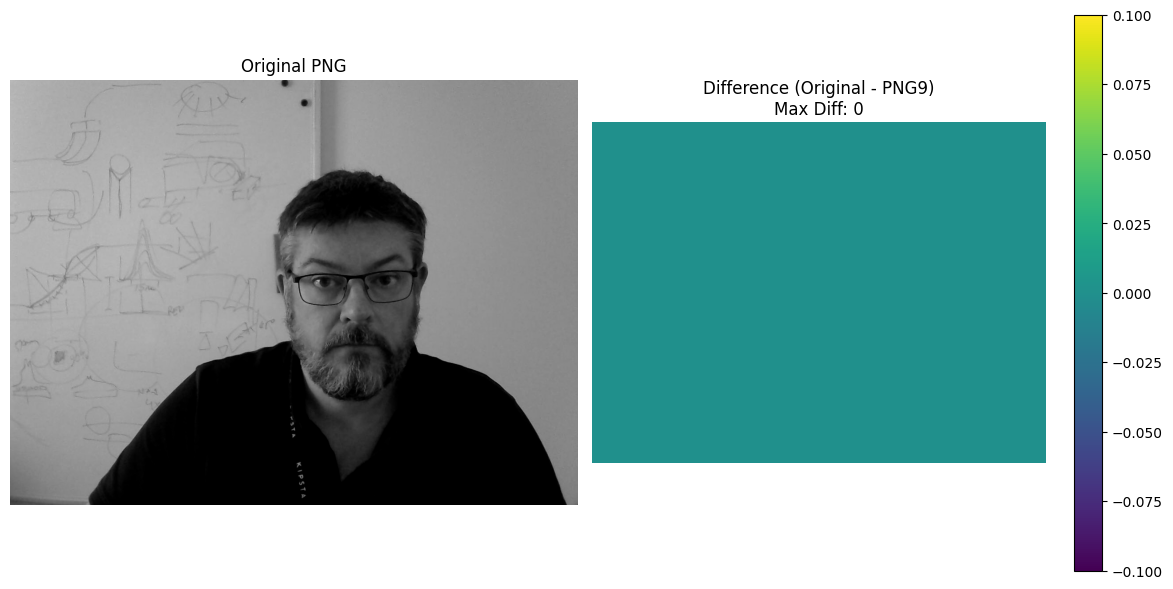


--- Comparing Original PNG vs. Lossless WebP ---
Shapes match: (960, 1280)
Maximum pixel difference: 4
Average pixel difference: 0.2901
Number of different pixels: 321531 / 1228800 [0.26]
Mean Squared Error (MSE): 0.3479
RESULT: Images differ!


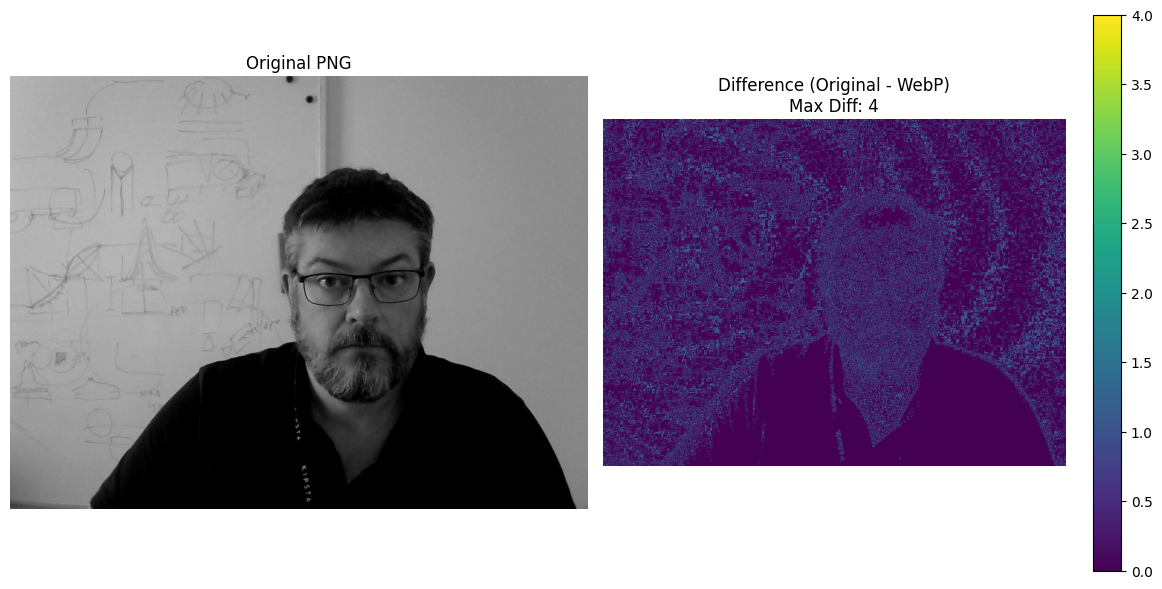

In [45]:
# --- Configuration ---
# (Same configuration and file loading logic as the previous comparison script)
# ... ensure original_image_path, png9_filepath, webp_filepath are defined and exist ...

# --- Load Images ---
print(f'Loading Original: {original_image_path.name}')
original_frame = cv2.imread(str(original_image_path), cv2.IMREAD_GRAYSCALE)

print(f'Loading PNG Level 9: {png9_filepath.name}')
png9_frame = cv2.imread(str(png9_filepath), cv2.IMREAD_GRAYSCALE)

print(f'Loading Lossless WebP: {webp_filepath.name}')
webp_frame = cv2.imread(str(webp_filepath), cv2.IMREAD_GRAYSCALE)

# --- Basic Validation ---
files_ok = True
if original_frame is None:
    print('[ERROR] Failed to load original frame.')
    files_ok = False
if png9_frame is None:
    print('[ERROR] Failed to load PNG9 frame.')
    files_ok = False
if webp_frame is None:
    print('[ERROR] Failed to load WebP frame.')
    files_ok = False

if files_ok:
    print('\n--- Comparing Original PNG vs. PNG Level 9 ---')
    if original_frame.shape == png9_frame.shape:
        print(f'Shapes match: {original_frame.shape}')
        diff_png9 = cv2.absdiff(original_frame, png9_frame)
        max_diff_png9 = np.max(diff_png9)
        mse_png9 = np.mean(
            (original_frame.astype(np.float64) - png9_frame.astype(np.float64)) ** 2
        )

        print(f'Maximum pixel difference: {max_diff_png9}')
        print(f'Average pixel difference: {np.mean(diff_png9):.4f}')
        print(f'Number of different pixels: {np.count_nonzero(diff_png9)} / {diff_png9.size}  [{np.count_nonzero(diff_png9)/diff_png9.size:.2f}]')
        print(f'Mean Squared Error (MSE): {mse_png9:.4f}')

        if max_diff_png9 == 0 and mse_png9 == 0.0:
            print('RESULT: Images are identical (Lossless).')
        else:
            print('RESULT: Images differ!')

        # --- Visualize Difference ---
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
        plt.title('Original PNG')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # Convert diff image to RGB for display (or show grayscale)
        # Showing the sum of differences across channels can highlight where any difference is
        diff_display = np.sum(diff_png9)  # Sum differences across BGR channels
        plt.imshow(diff_png9, cmap='viridis')  # Use a colormap to see non-zero values
        plt.title(f'Difference (Original - PNG9)\nMax Diff: {max_diff_png9}')
        plt.colorbar()  # Show color scale for difference magnitude
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        # --- End Visualization ---

    else:
        print(
            f'[ERROR] Shape mismatch! Original: {original_frame.shape}, PNG9: {png9_frame.shape}'
        )

    print('\n--- Comparing Original PNG vs. Lossless WebP ---')
    if original_frame.shape == webp_frame.shape:
        print(f'Shapes match: {original_frame.shape}')
        diff_webp = cv2.absdiff(original_frame, webp_frame)
        max_diff_webp = np.max(diff_webp)
        mse_webp = np.mean(
            (original_frame.astype(np.float64) - webp_frame.astype(np.float64)) ** 2
        )

        print(f'Maximum pixel difference: {max_diff_webp}')
        print(f'Average pixel difference: {np.mean(diff_webp):.4f}')
        print(
            f'Number of different pixels: {np.count_nonzero(diff_webp)} / {diff_webp.size} [{np.count_nonzero(diff_webp)/diff_webp.size:.2f}]'
        )
        print(f'Mean Squared Error (MSE): {mse_webp:.4f}')

        if max_diff_webp == 0 and mse_webp == 0.0:
            print('RESULT: Images are identical (Lossless).')
        else:
            print('RESULT: Images differ!')

        # --- Visualize Difference ---
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
        plt.title('Original PNG')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        diff_display = np.sum(diff_webp)  # Sum differences across BGR channels
        plt.imshow(diff_webp, cmap='viridis')
        plt.title(f'Difference (Original - WebP)\nMax Diff: {max_diff_webp}')
        plt.colorbar()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        # --- End Visualization ---

    else:
        print(
            f'[ERROR] Shape mismatch! Original: {original_frame.shape}, WebP: {webp_frame.shape}'
        )

else:
    print('\nComparison aborted due to image loading errors.')

# --- End of script ---
